<a href="https://colab.research.google.com/github/arthurcassemiroo/Music-recommender-/blob/main/recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.6/237.6 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
from skimage import io

In [6]:
scope = "user-library-read playlist-modify-private"
Oauth = SpotifyOAuth(
    scope=scope,
    redirect_uri='htttp://localhost:8888/callback',
    client_id = 'c8ef9677243a4072b25672ab979eeda0',
    client_secret = '26f85367a7f645fd87c4915b72976abd'
)

client_credentials_manager = SpotifyClientCredentials(client_id = 'c8ef9677243a4072b25672ab979eeda0',
                                                      client_secret = '26f85367a7f645fd87c4915b72976abd')

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [7]:
data = pd.read_csv('https://raw.githubusercontent.com/arthurcassemiroo/Music-recommender-/main/Dados_totais.csv')
data_years = pd.read_csv('https://raw.githubusercontent.com/arthurcassemiroo/Music-recommender-/main/dados_musicas_ano.csv')
data_genres = pd.read_csv('https://raw.githubusercontent.com/arthurcassemiroo/Music-recommender-/main/dados_musicas_genero.csv')

In [8]:
data = data.drop(['explicit', 'key', 'mode'], axis = 1)
data_genres = data_genres.drop(['key', 'mode'], axis = 1)
data_years = data_years[data_years['year'] >= 2000]
data_years = data_years.drop(['key', 'mode'], axis = 1)
data_years = data_years.reset_index()

In [9]:
SEED = 1224
np.random.seed(1224)
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2, random_state=SEED))])

ohe = OneHotEncoder(dtype=int)
columns_ohe = ohe.fit_transform(data[['artists']]).toarray()
data2 = data.drop('artists', axis=1)
music_data_dummies = pd.concat([data2, pd.DataFrame(columns_ohe, columns= ohe.get_feature_names_out(['artists']))], axis = 1)

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=0.7, random_state=SEED))])

music_embedding_pca = pca_pipeline.fit_transform(music_data_dummies.drop(['id', 'name', 'artists_song'], axis=1))
projection_m = pd.DataFrame(data=music_embedding_pca)

kmeans_pca_pipeline = KMeans(n_clusters=50, verbose=False, random_state=SEED)
kmeans_pca_pipeline.fit(projection_m)
data['cluster_pca'] = kmeans_pca_pipeline.predict(projection_m)
projection_m['cluster_pca'] = kmeans_pca_pipeline.predict(projection_m)
projection_m['artist'] = data['artists']
projection_m['song'] = data['artists_song']

In [36]:
def recommender(music_name):
  cluster = list(projection_m[projection_m['song'] == music_name]['cluster_pca'])[0]
  recommended_songs = projection_m[projection_m['cluster_pca'] == cluster][[0, 1, 'song']]
  x_musica = list(projection_m[projection_m['song'] == music_name][0])[0]
  y_musica = list(projection_m[projection_m['song'] == music_name][1])[0]
  distancias = euclidean_distances(recommended_songs[[0, 1]], [[x_musica, y_musica]])
  recommended_songs['id'] = data['id']
  recommended_songs['distancias'] = distancias
  recommended = recommended_songs.sort_values('distancias').head(10)
  playlist_id = recommended['id']
  url = []
  name = []
  artists = []
  for i in playlist_id:
    track = sp.track(i)
    url.append(track['album']['images'][1]['url'])
    name.append(track['name'])
    artists.append(track['artists'][0]['name']),
    plt.rcParams["figure.figsize"] = (15,10)
    columns = 5
  for i, u in enumerate(url):
      ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
      image = io.imread(u)
      plt.imshow(image)
      ax.get_yaxis().set_visible(False)
      plt.xticks(color = 'w', fontsize = 0.1)
      plt.yticks(color = 'w', fontsize = 0.1) 
      plt.xlabel(name[i] + '\n' + artists[i], fontsize = 8)
      plt.tight_layout(h_pad=0.7, w_pad=0)
      plt.subplots_adjust(wspace=None, hspace=None)
      plt.tick_params(bottom = False)
      plt.grid(visible=None)
  plt.show()

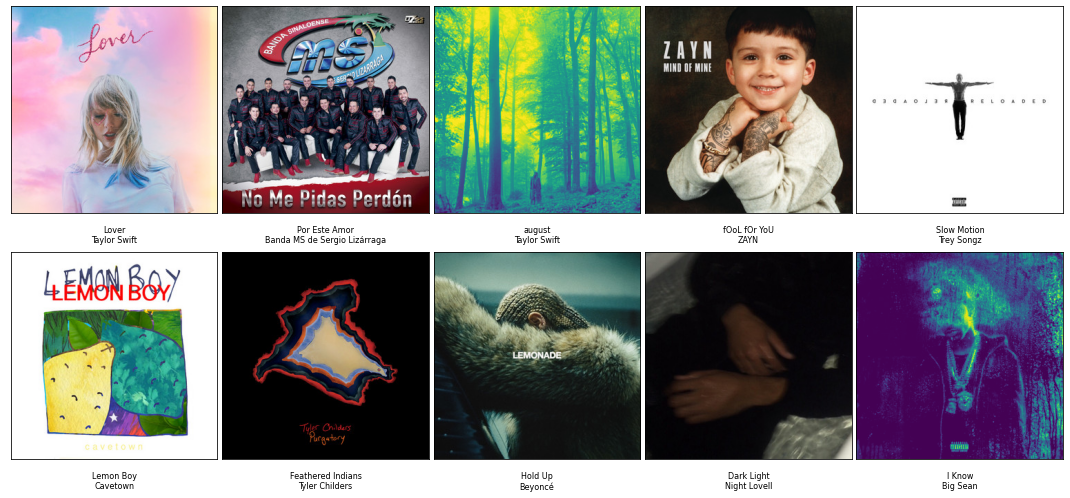

In [37]:
recommender('Taylor Swift - Lover')